# Git Shoes

## Project Goals

- Determine the programming language used in a given GitHub Repository by examining the words used in the readme file.

- We honed in specifically on repositories with the word 'shoes' in the name.

## Imports Used

In [1]:
#basic data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# web scraping and nlp imports
import nltk
import re
import os
import json
import requests
import unicodedata

from bs4 import BeautifulSoup

from pprint import pprint
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#classification imports
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, recall_score

from time import strftime

from sklearn.model_selection import train_test_split

from wordcloud import WordCloud

# importing created modules 
from env import get_connection
import acquire as ac
import prepare as prep
import explore_functions as ex
import modeling as md

from acquire import scrape_github_data

import warnings
warnings.filterwarnings("ignore")

seed = 42

# Acquisition

<div class="alert alert-block alert-info">

- We obtained our data through the GitHub api, through the use of many functions within the acquire.py file.

- We started with 198 rows in our data, with each row being an individual repository.

In [2]:
# pulling the data from the json file
df = pd.read_json('repos.json')

df.head()

,repo,language,readme_contents
0,justinmk/vim-sneak,Vim Script,sneak.vim 👟\n================\n\nJump to any l...
1,google-research-datasets/Objectron,Jupyter Notebook,"\n<div align=""center"">\n\n# Objectron Dataset\..."
2,shoes/shoes4,Ruby,# Shoes 4 [![Linux Build Status](https://secur...
3,shoes/shoes-deprecated,C,# THIS REPO IS NO LONGER ACTIVE!\n\n**Looking ...
4,filamentgroup/shoestring,JavaScript,:warning: This project is archived and the rep...


# Preparation

<div class="alert alert-block alert-info">

In order to make sense of our data, we had to clean it up quite a bit. We started by doing:

- There were two repositories that had nothing to do with out chosen topic, shoes, and so we dropped those two.
    
- There were also 13 rows that had no readme files, and thus those were also dropped.
    
- Next, we got a value count of the various languages we had, and anything that was beloew 10 we consolidated into one category, 'other'
    
- After that, we created a series for each unique language as well as got a value count for each
    
- After creating those other variables for later exploration, we cleaned up our readme entries by normalizing the words to removing accents and other symbols that arent helpful, as well as removing stopwords and making each word its own token to make it easier to work with later.
    
- Lastly, because we were working with a reasonable amount of data, we both stemmed and lemmatized so that we could determine what works better on our models.

In [3]:
#initial cleaning function
df = ex.clean_df(df)

In [4]:
df.head()

,repo,language,readme_contents
0,justinmk/vim-sneak,other,sneak.vim 👟\n================\n\nJump to any l...
1,google-research-datasets/Objectron,other,"\n<div align=""center"">\n\n# Objectron Dataset\..."
2,shoes/shoes4,ruby,# Shoes 4 [![Linux Build Status](https://secur...
3,shoes/shoes-deprecated,other,# THIS REPO IS NO LONGER ACTIVE!\n\n**Looking ...
4,filamentgroup/shoestring,javascript,:warning: This project is archived and the rep...


In [5]:
#getting the word frequencies and series of all words used via function
word_freq, all_words = ex.word_counts(df)

In [6]:
#second layer of cleaning the dataframe
prep.prep_article_data(df, 'readme_contents')

,repo,readme_contents,clean,stemmed,lemmatized
0,justinmk/vim-sneak,sneak.vim 👟\n================\n\nJump to any l...,sneakvim jump location specified two character...,sneakvim jump locat specifi two charact sneak ...,sneakvim jump location specified two character...
1,google-research-datasets/Objectron,"\n<div align=""center"">\n\n# Objectron Dataset\...",div aligncenter objectron dataset objectron da...,div aligncent objectron dataset objectron data...,div aligncenter objectron dataset objectron da...
2,shoes/shoes4,# Shoes 4 [![Linux Build Status](https://secur...,shoes 4 linux build statushttpssecuretraviscio...,shoe 4 linux build statushttpssecuretraviscior...,shoe 4 linux build statushttpssecuretraviscior...
3,shoes/shoes-deprecated,# THIS REPO IS NO LONGER ACTIVE!\n\n**Looking ...,repo longer active looking continuing shoes 3 ...,repo longer activ look continu shoe 3 support ...,repo longer active looking continuing shoe 3 s...
4,filamentgroup/shoestring,:warning: This project is archived and the rep...,warning project archived repository longer mai...,warn project archiv repositori longer maintain...,warning project archived repository longer mai...
...,...,...,...,...,...
191,flutter-devs/flutter_ecommerce_shoes,# Flutter eCommerce UI Demo\n\nA sample applic...,flutter ecommerce ui demo sample application s...,flutter ecommerc ui demo sampl applic show eco...,flutter ecommerce ui demo sample application s...
194,kaushiksheel/ShoesStore-Frontend-Typescript,# Shoe Store Ecommerce Application\n\n## Intro...,shoe store ecommerce application introduction ...,shoe store ecommerc applic introduct ecommerc ...,shoe store ecommerce application introduction ...
195,devyn/shoes-web,== Welcome to Radiant\n\nRadiant is a no-fluff...,welcome radiant radiant nofluff open source co...,welcom radiant radiant nofluff open sourc cont...,welcome radiant radiant nofluff open source co...
196,mjokic/adidas_carter,# adidas_carter\n\nAdidas carter helps you car...,adidas_carter adidas carter helps cart shoes a...,adidas_cart adida carter help cart shoe adida ...,adidas_carter adidas carter help cart shoe adi...


In [7]:
df.head()

,repo,language,readme_contents,clean,stemmed,lemmatized
0,justinmk/vim-sneak,other,sneak.vim 👟\n================\n\nJump to any l...,sneakvim jump location specified two character...,sneakvim jump locat specifi two charact sneak ...,sneakvim jump location specified two character...
1,google-research-datasets/Objectron,other,"\n<div align=""center"">\n\n# Objectron Dataset\...",div aligncenter objectron dataset objectron da...,div aligncent objectron dataset objectron data...,div aligncenter objectron dataset objectron da...
2,shoes/shoes4,ruby,# Shoes 4 [![Linux Build Status](https://secur...,shoes 4 linux build statushttpssecuretraviscio...,shoe 4 linux build statushttpssecuretraviscior...,shoe 4 linux build statushttpssecuretraviscior...
3,shoes/shoes-deprecated,other,# THIS REPO IS NO LONGER ACTIVE!\n\n**Looking ...,repo longer active looking continuing shoes 3 ...,repo longer activ look continu shoe 3 support ...,repo longer active looking continuing shoe 3 s...
4,filamentgroup/shoestring,javascript,:warning: This project is archived and the rep...,warning project archived repository longer mai...,warn project archiv repositori longer maintain...,warning project archived repository longer mai...


# Exploration

In [8]:
# a brief snippet of the word frequency table
word_freq

,other,javascript,html,dart,ruby,python,all_counts
run,55,0,8,9,53,26,196
img,38,0,7,15,2,7,101
project,37,0,35,22,27,15,202
file,36,0,65,0,53,28,224
use,36,0,19,3,49,39,200
...,...,...,...,...,...,...,...
palette,0,0,0,0,0,0,1
reserve,0,0,0,0,0,0,1
constructive,0,0,0,0,0,0,1
receiving,0,0,0,0,0,0,1


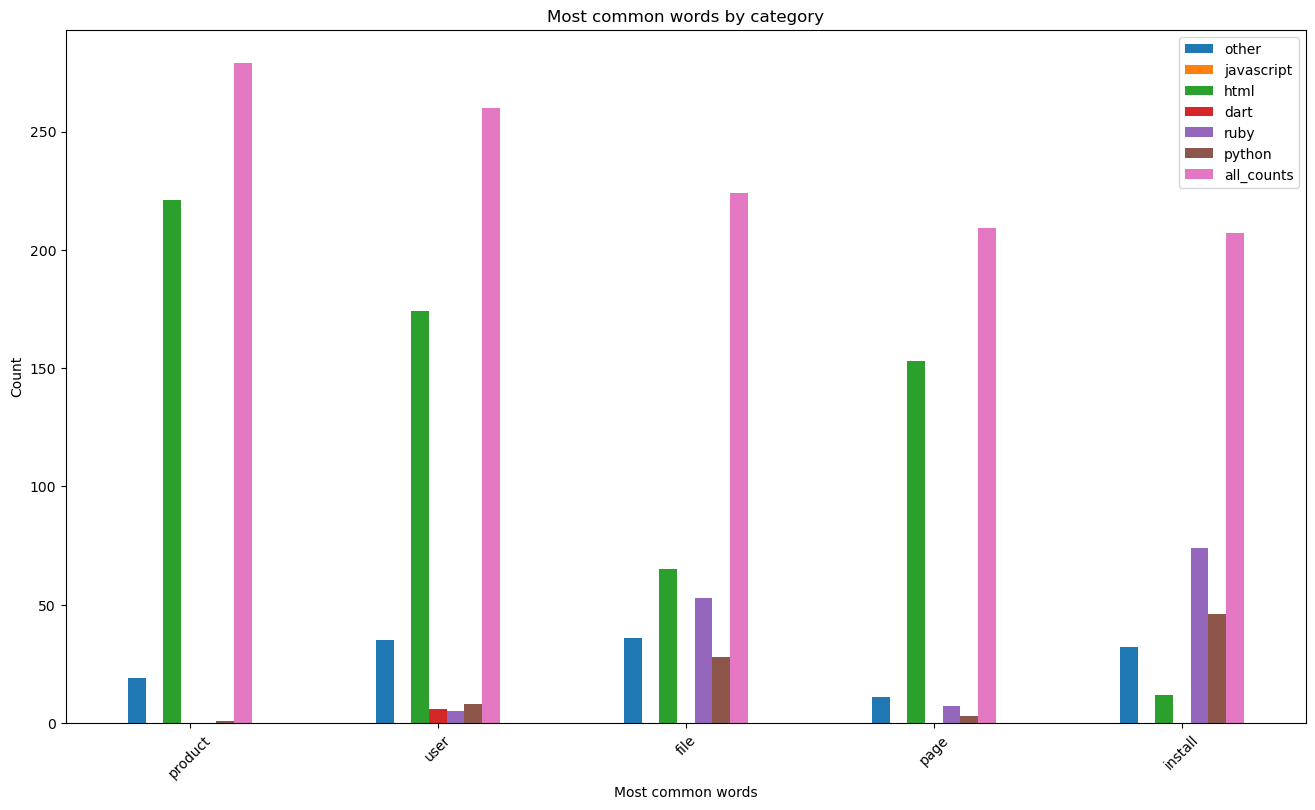

In [9]:
#function for first visual
ex.word_count(word_freq)

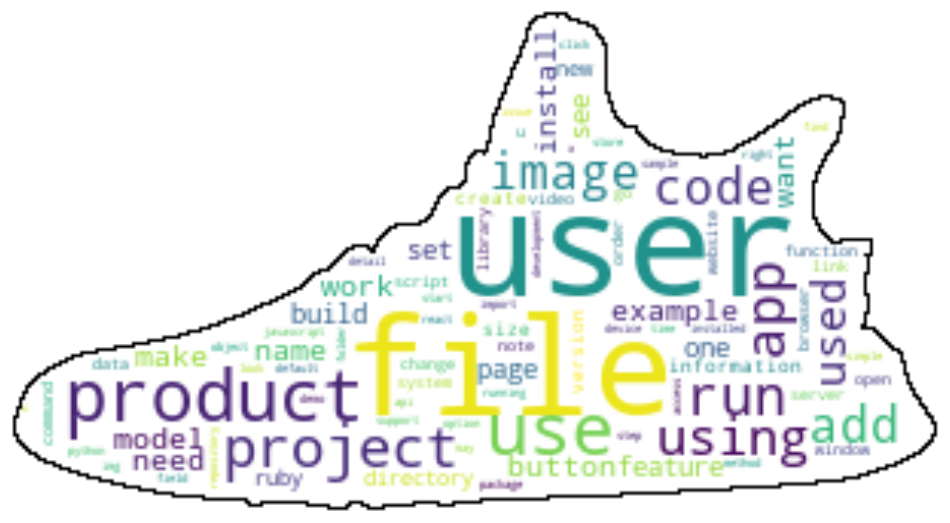

In [10]:
#function for second visual
ex.shoe_cloud(all_words)

# Modeling

In [11]:
# splitting the data into train validate and test datasets
train, validate, test = ex.split_train_test(df, 'language')

train.shape, validate.shape, test.shape

((91, 6), (55, 6), (37, 6))

In [12]:
#splitting further into x and y datasets
X_train, y_train, X_validate, y_validate, X_test, y_test = ex.xy_train(train, validate, test, 'language')

In [13]:
#getting a head of the dataframe
X_train.head(1)

,repo,readme_contents,clean,stemmed,lemmatized
39,trananhtuat/nike-shoes-landing-page,# nike-shoes-landing-page\n Make Animated Nike...,nikeshoeslandingpage make animated nike shoes ...,nikeshoeslandingpag make anim nike shoe land p...,nikeshoeslandingpage make animated nike shoe l...


In [14]:
#creating our baseline accuracy
df['baseline'] = df['language'].value_counts().idxmax()

baseline = (df['language'] == df['baseline']).mean()

print(f'Our baseline is: {baseline:.4}')

Our baseline is: 0.2514


In [15]:
#function for the best random forest model on the stemmed data
md.random_forest(X_train['stemmed'], y_train, X_validate['stemmed'], y_validate)

Train Accuracy:    0.7253
Validate Accuracy: 0.4364


In [16]:
#function for the best random forest model on the lemmatized data
md.random_forest(X_train['lemmatized'], y_train, X_validate['lemmatized'], y_validate)

Train Accuracy:    0.7033
Validate Accuracy: 0.4182


In [17]:
#function for the best decision tree model on the stemmed data
md.dec_tree(X_train['stemmed'], y_train, X_validate['stemmed'], y_validate)

Train Accuracy:    0.5604
Validate Accuracy: 0.4909


In [18]:
#function for the best decision tree on the lemmatized data
md.dec_tree(X_train['lemmatized'], y_train, X_validate['lemmatized'], y_validate)

Train Accuracy:    0.5604
Validate Accuracy: 0.4909


In [19]:
#function for the best knn model on the stemmed data
md.knn(X_train['stemmed'], y_train, X_validate['stemmed'], y_validate)

Train Accuracy:    0.5824
Validate Accuracy: 0.2545


In [20]:
#function for the best knn model on the lemmatized data
md.knn(X_train['lemmatized'], y_train, X_validate['lemmatized'], y_validate)

Train Accuracy:    0.5824
Validate Accuracy: 0.2364


In [21]:
#function to print numbers for the best overall model
md.dec_test_accuracy(X_train['stemmed'], y_train, X_validate['stemmed'], y_validate, X_test['stemmed'], y_test)

Train Accuracy:    0.5604
Validate Accuracy: 0.4909
Test Accuracy:     0.4324


## Modeling Conclusions

- The best overall model, while attempting to account for overfitting, was the decision tree model with a max depth of 3

- We ended up going from 25% accuracy to 43% on our test set, which is an increase 72$ increase!


## Summary 


In this project, we examined the programming languages of Github repositories based on words mentioned in README.md files that included the word 'shoes'. By acquiring using web scraping techniques, exploring the data and creating classification models, using the decision tree, we established a model to accurately predict the programming language 43 pc of the time.

Baseline: 25%
Final Model: 43%
Performance Increase: 73%

## Recommendations

- Explore some quadgrams.

- Visualize the quadgrams via word clouds and bar plots.

## Next Steps

- Use count vectorization to incorporate bigrams and trigrams.

- Further explore TF-IDF and bag-of-words.